The following are key descriptions of analytic scores that are being used to hopefully identify key behavioural archetypes within the wallet data:

 - **Behavioural Volatility Score**: The Behavioural Volatility Score quantifies how variable or erratic a wallet's transaction behavior is over time. It measures the inconsistency in transaction amounts and timing for each wallet. High scores indicate wallets with irregular, unpredictable activity, while low scores suggest regular, stable transaction patterns. The score is typically derived using statistical analysis of transaction histories, such as calculating the standard deviation or other measures of dispersion in transaction frequency and amounts. This helps identify users whose behavior deviates from the norm, which can be useful for segmentation, risk assessment, or anomaly detection. 

- **Revenue Proxy Score**: estimates the potential revenue contribution of each wallet by combining several aspects of user activity. It is calculated as a weighted sum of three main components: transaction activity (frequency of transactions multiplied by their average value), DEX/DeFi engagement (the number of decentralized exchange and DeFi events, weighted by average transfer value), and bridge activity (the total volume transferred via bridges). By aggregating these factors, the score highlights wallets that are likely to be high-value users based on their transaction patterns and engagement with DeFi and cross-chain services.

- **Cross Domain Engagement Score**: The cross domain engagement score is a metric that quantifies how diversely a cryptocurrency wallet interacts across different event types or domains. It is calculated using Shannon entropy, which measures the unpredictability or diversity of event participation for each wallet. A score near 1 means the wallet's activity is evenly spread across many event types (high engagement diversity). A score near 0 means the wallet's activity is concentrated in few or just one event type (low engagement diversity)

- **Interaction Mode Score**: A median value is produced for each of DEX_EVENTS, CEX_EVENTS, BRIDGE_EVENTS and DEFI_EVENTS from clustering results where a cluster median for each feature is selected from the most prominant cluster for that event type. The distance score measures how much a wallet's behavior deviates from the median, after normalizing for feature variability and weighting by the wallet's activity profile. A higher score means the wallet acts more unusually compared to typical behavior, with the score reflecting both the size and importance of these differences. The typical behaviour being a value of an EVENT feature engagement that is prominant and high.

- **Activity-Based Clustering (UMAP + HDBSCAN)**: Groups wallets into clusters based on their activity patterns using a two-step pipeline: UMAP for dimensionality reduction and HDBSCAN for density-based clustering. This model reveals natural groupings or archetypes in the user base, helping to identify segments with similar behaviors. 


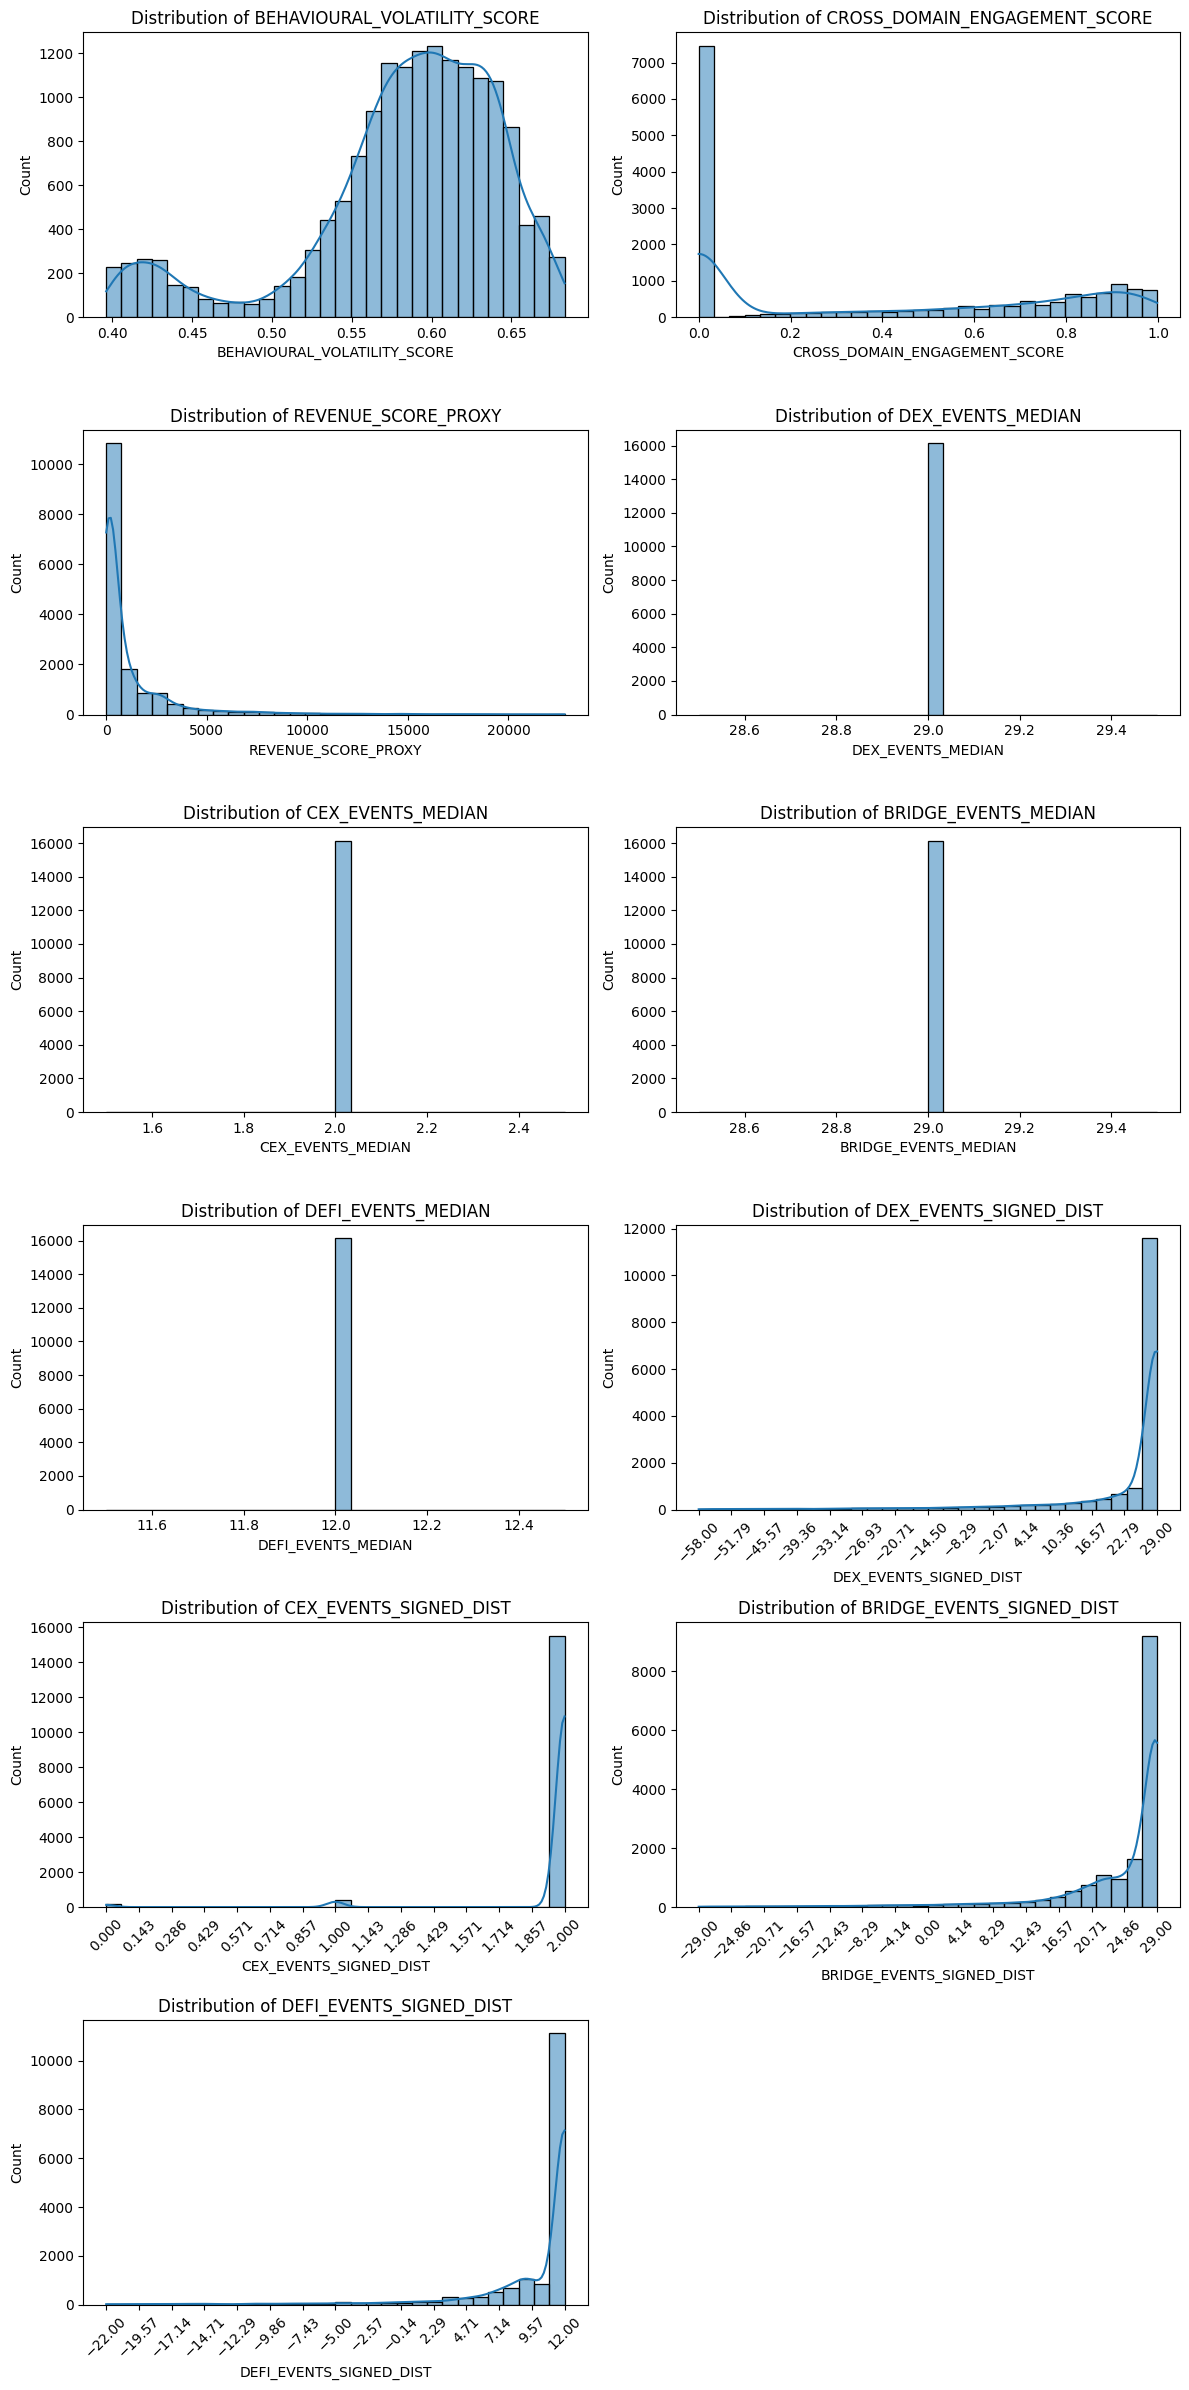

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_score_distributions(df, score_cols, bottom_percentile=0, top_percentile=100):
    """
    Plots distributions for each analytic score column, with optional exclusion of bottom/top percentiles.
    For *_SIGNED_DIST columns, increase x-tick frequency for readability.
    """
    signed_dist_cols = [c for c in score_cols if c.endswith('_SIGNED_DIST')]
    df_scores = df[score_cols].copy()
    # Remove bottom/top percentiles if specified
    if bottom_percentile > 0 or top_percentile < 100:
        for col in score_cols:
            low = np.percentile(df_scores[col], bottom_percentile)
            high = np.percentile(df_scores[col], top_percentile)
            df_scores = df_scores[(df_scores[col] >= low) & (df_scores[col] <= high)]
    num_cols = len(score_cols)
    fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(12, 4 * ((num_cols + 1) // 2)))
    axes = axes.flatten()
    for i, col in enumerate(score_cols):
        sns.histplot(df_scores[col], ax=axes[i], kde=True, bins=30)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        if col in signed_dist_cols:
            ticks = np.linspace(df_scores[col].min(), df_scores[col].max(), 15)
            axes[i].set_xticks(ticks)
            for label in axes[i].get_xticklabels():
                label.set_rotation(45)
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

# Load the data
scores_path = '../data/processed_data/merged_analytic_scores.csv'
df = pd.read_csv(scores_path)
# Get all columns after 'activity_cluster_label'
start_col = df.columns.get_loc('activity_cluster_label') + 1
score_cols = df.columns[start_col:]

# Example usage: exclude bottom 1% and top 99%
plot_score_distributions(df, score_cols, bottom_percentile=2.5, top_percentile=97.5)
# To plot all data, use: plot_score_distributions(df, score_cols)


--- Cluster 1 (11390 wallets) ---


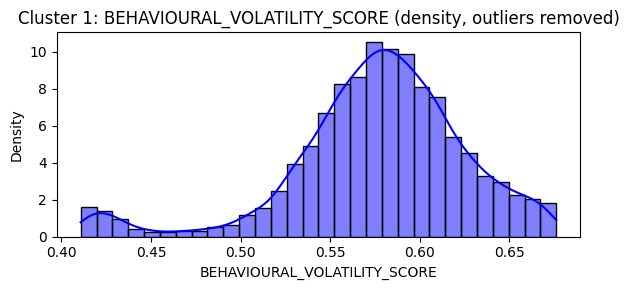

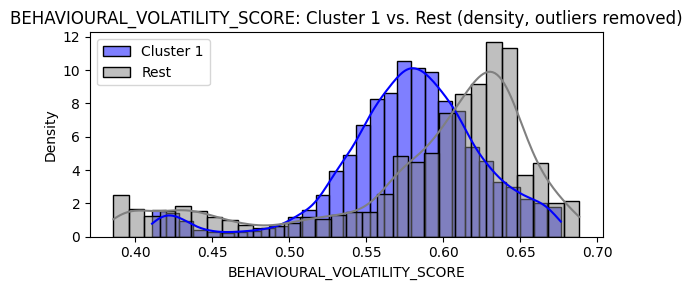

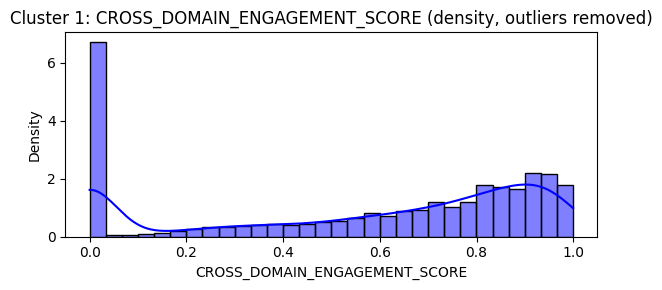

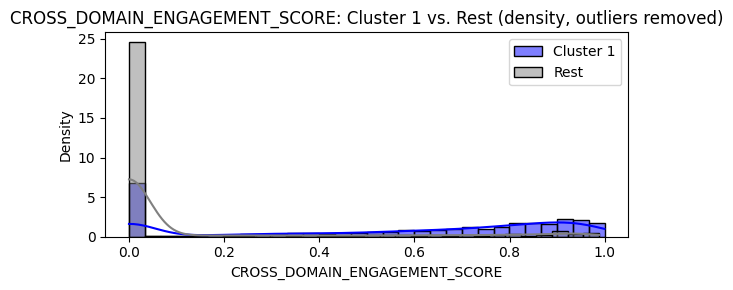

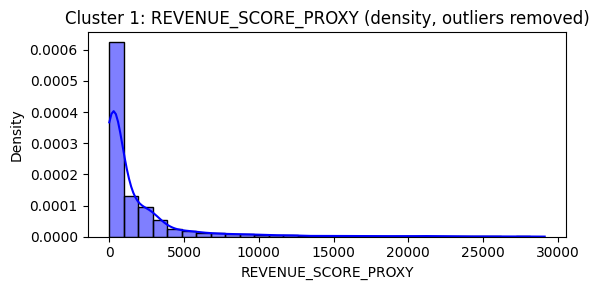

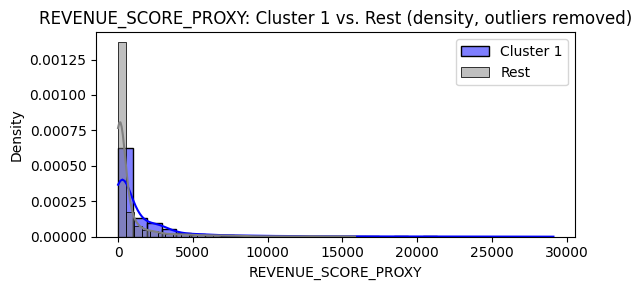

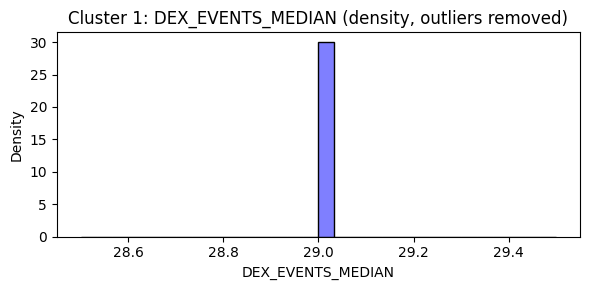

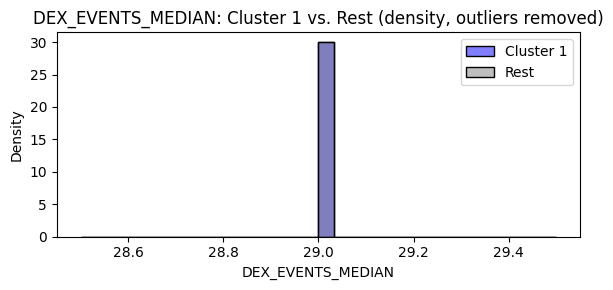

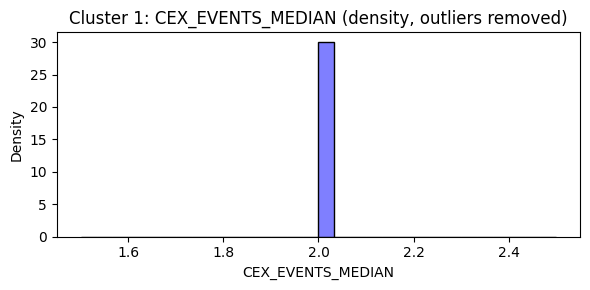

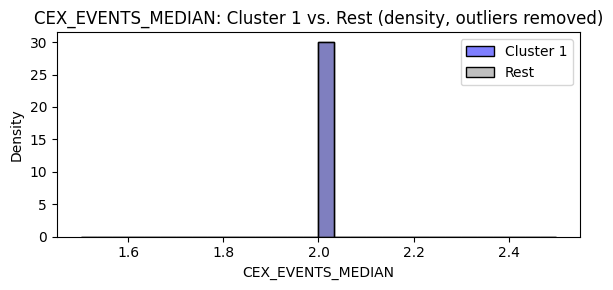

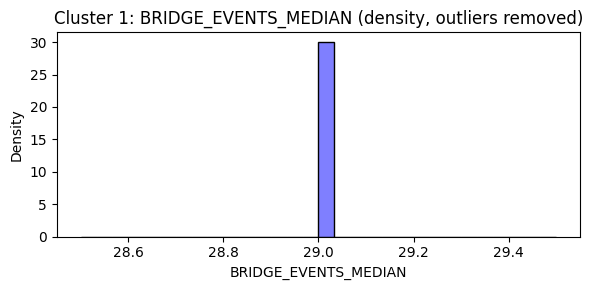

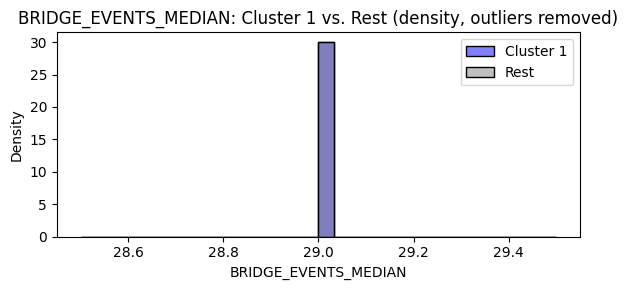

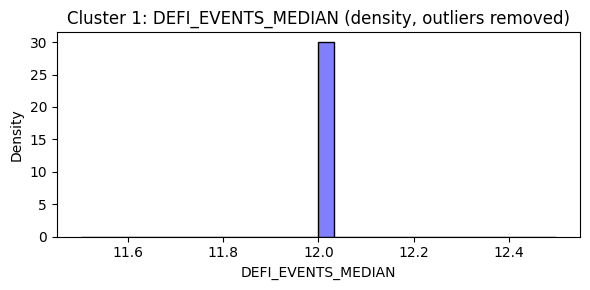

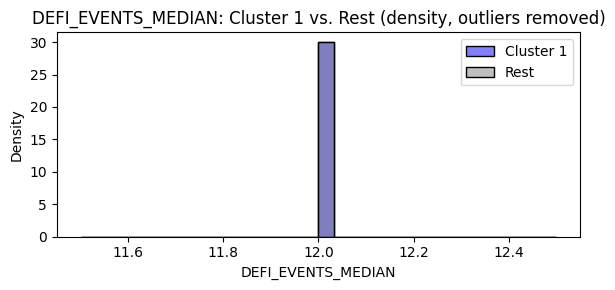

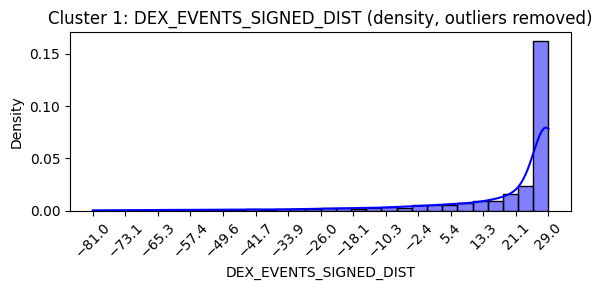

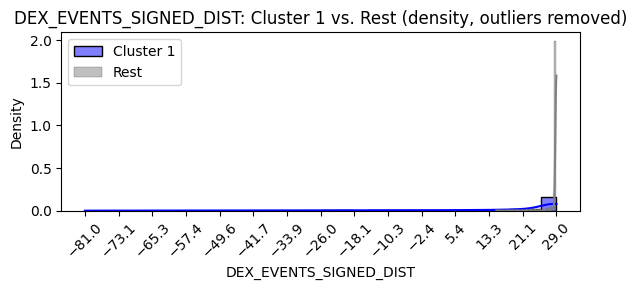

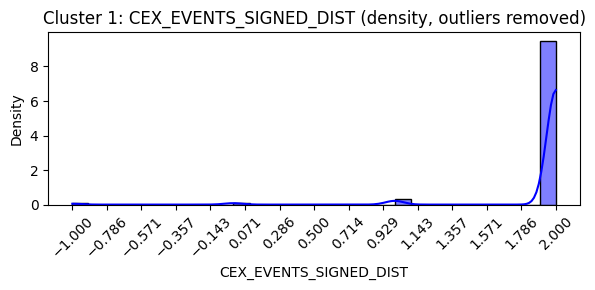

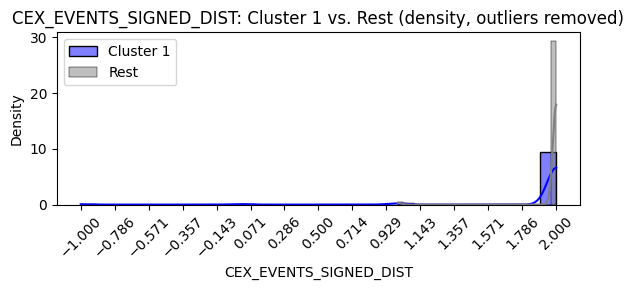

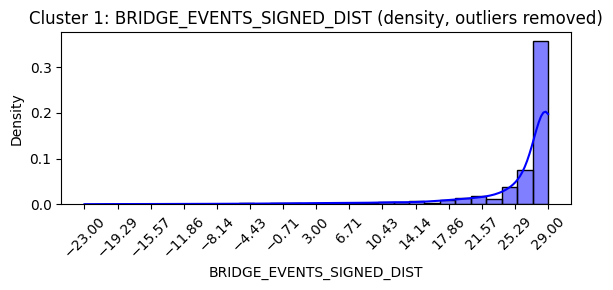

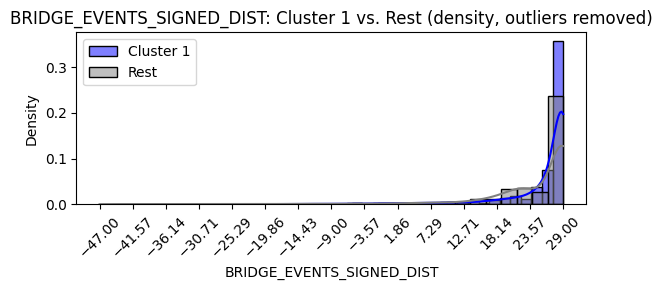

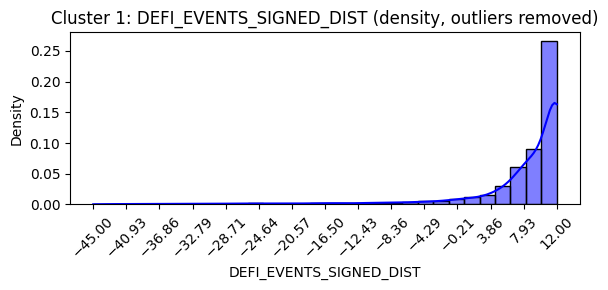

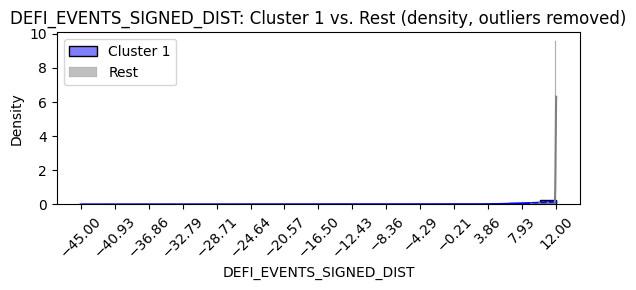


--- Cluster 0 (8713 wallets) ---


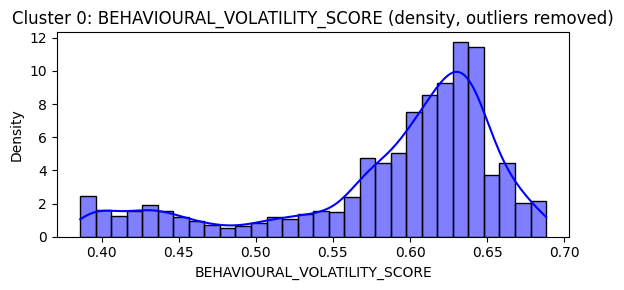

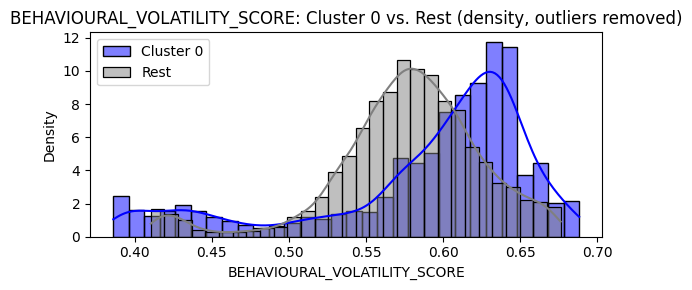

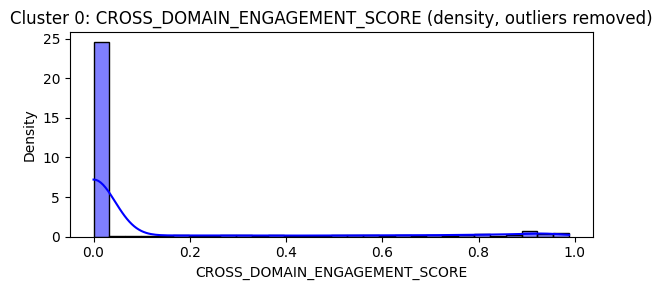

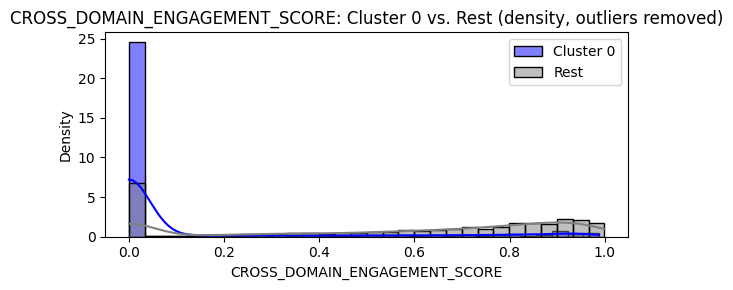

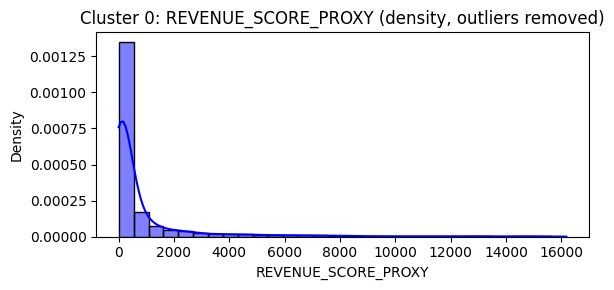

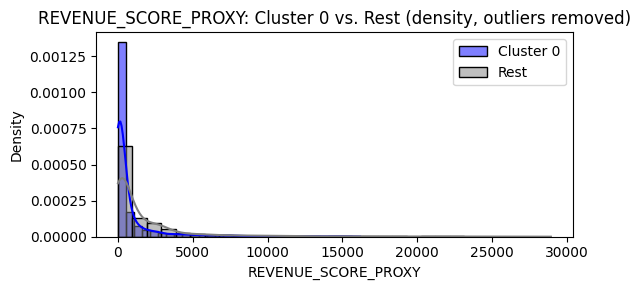

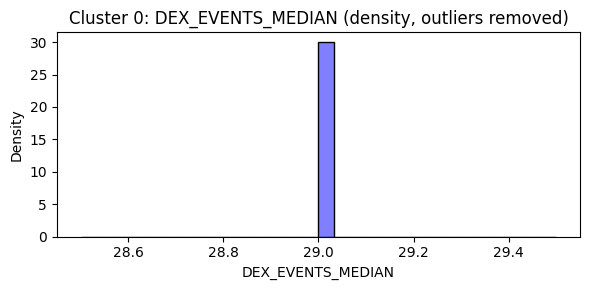

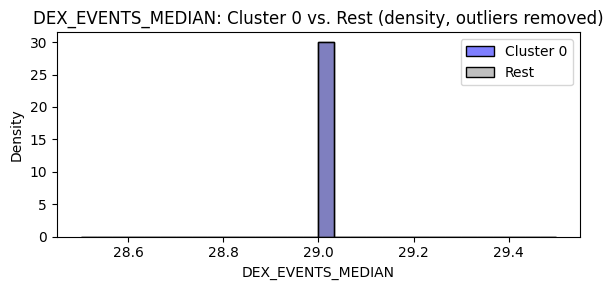

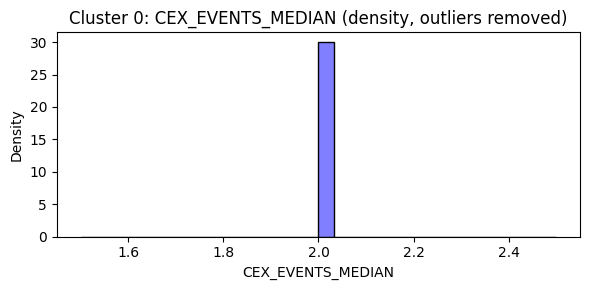

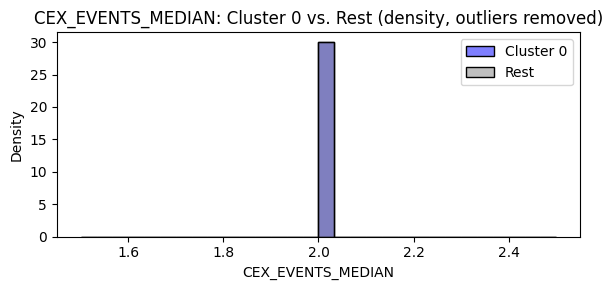

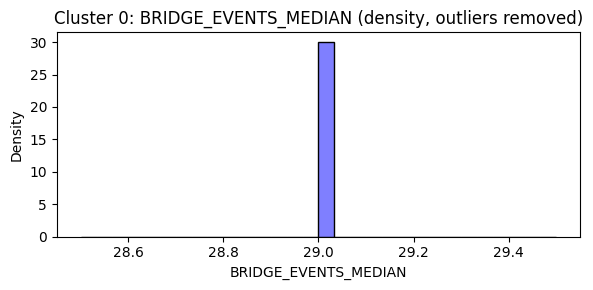

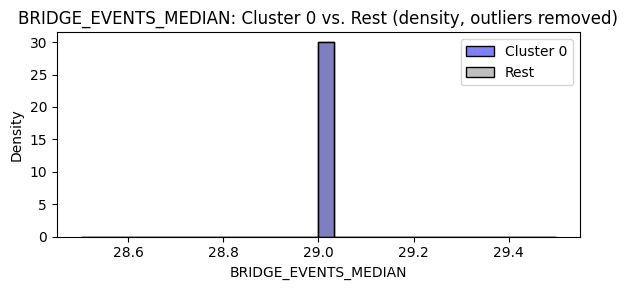

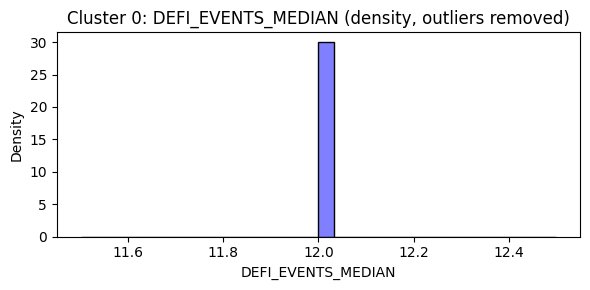

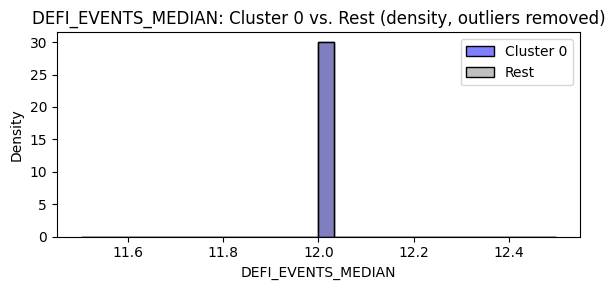

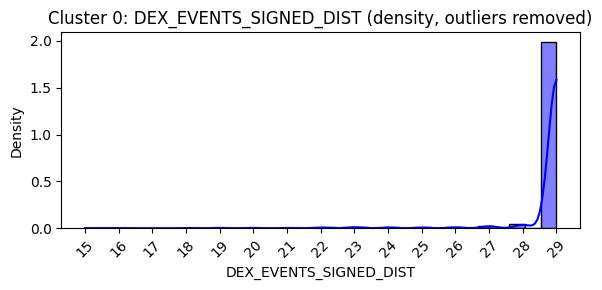

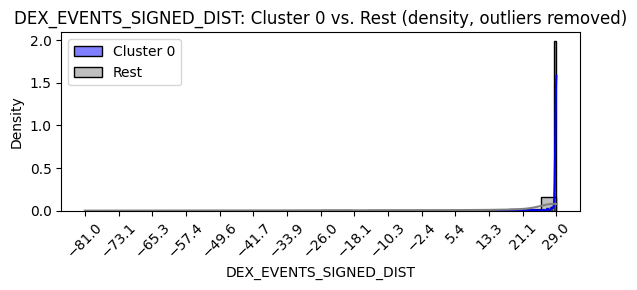

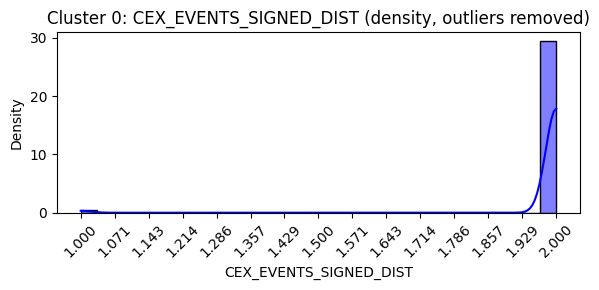

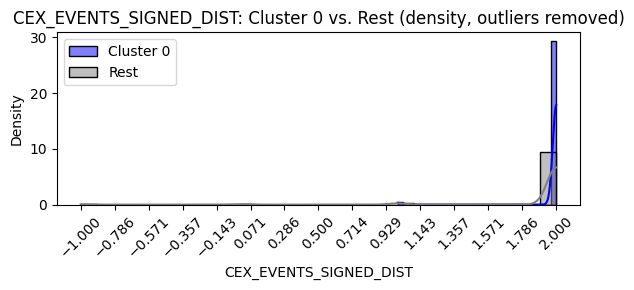

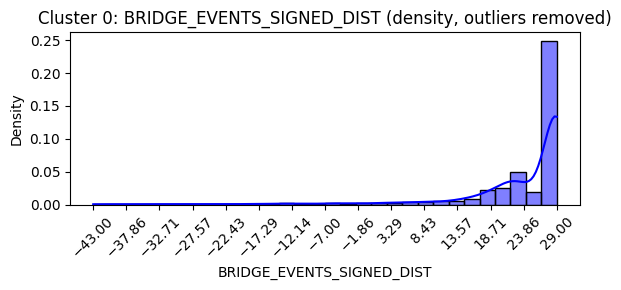

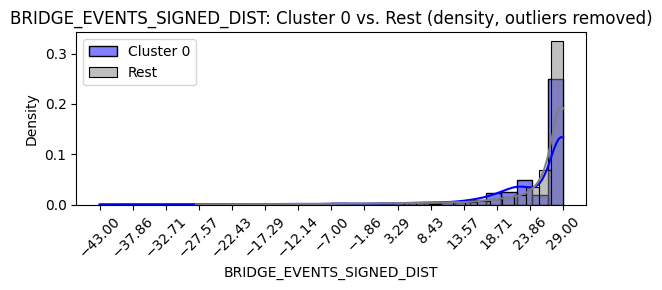

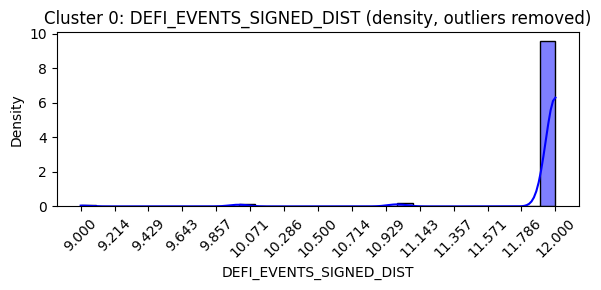

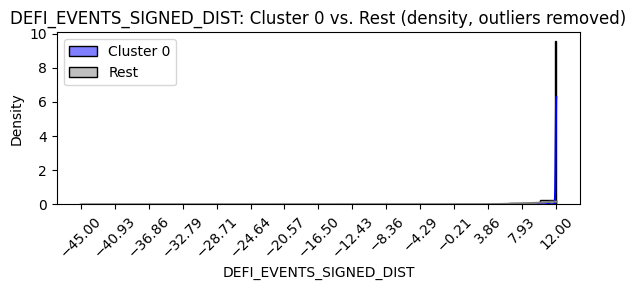


--- Cluster -1 (71 wallets) ---


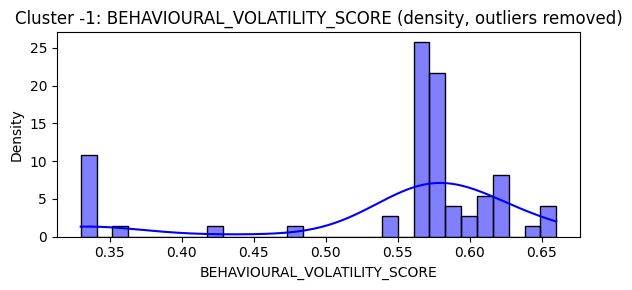

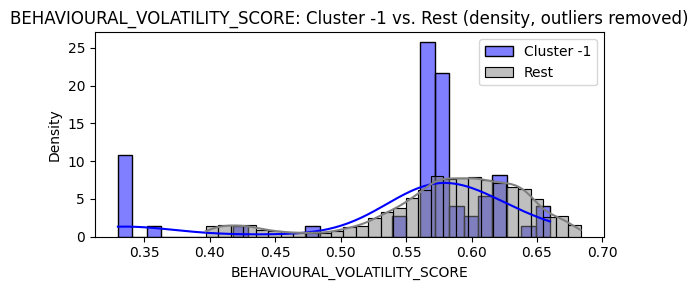

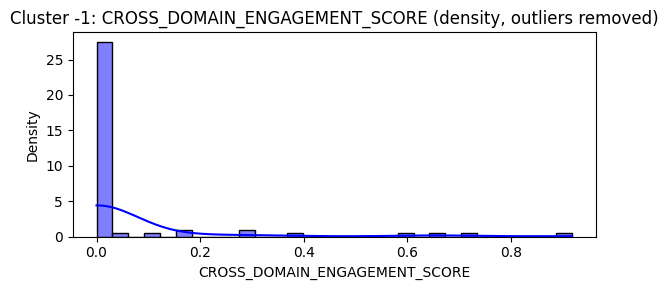

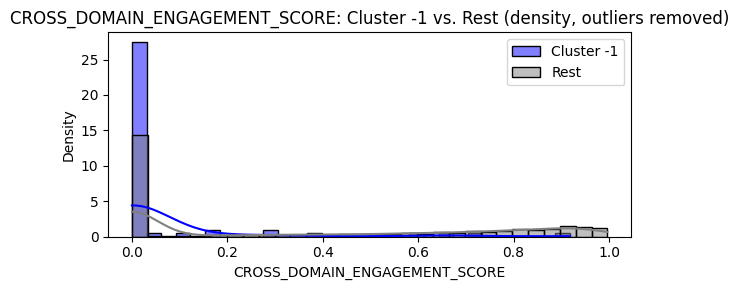

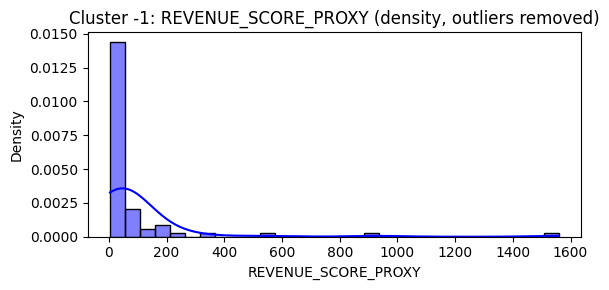

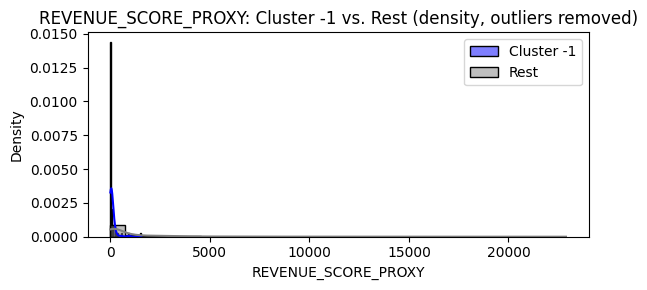

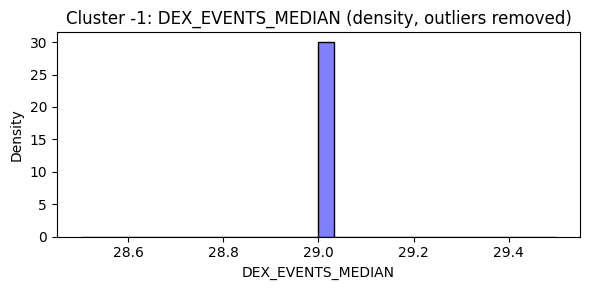

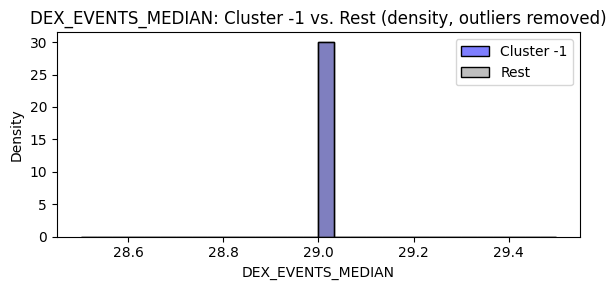

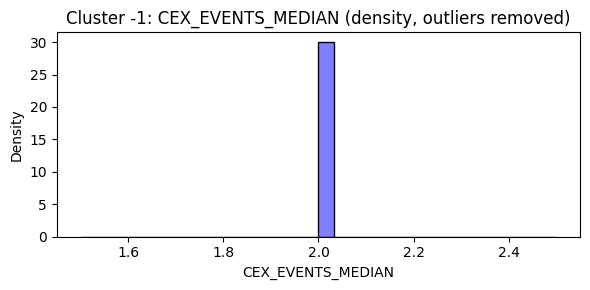

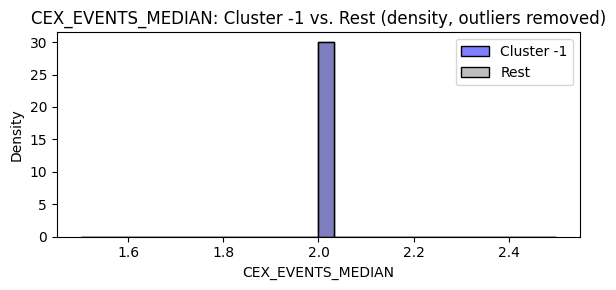

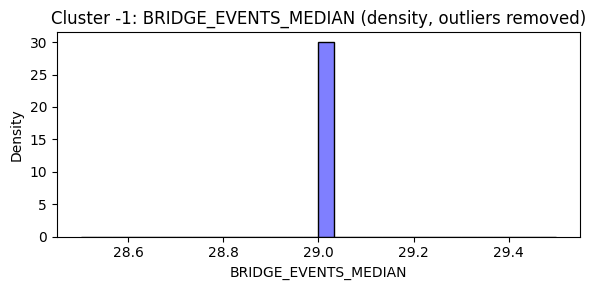

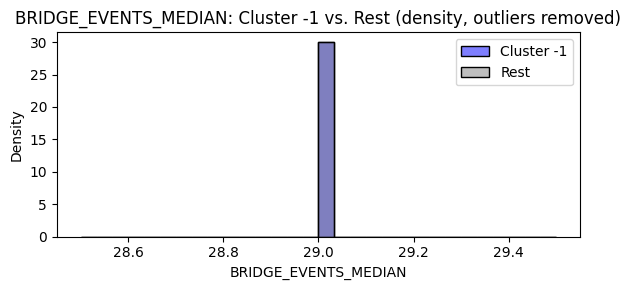

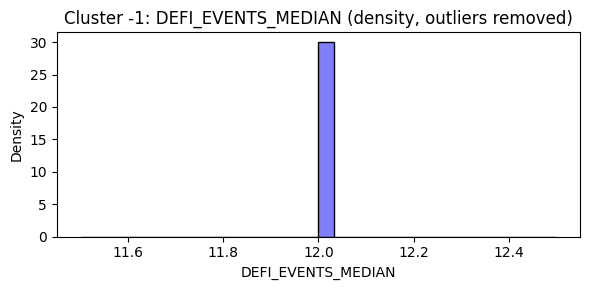

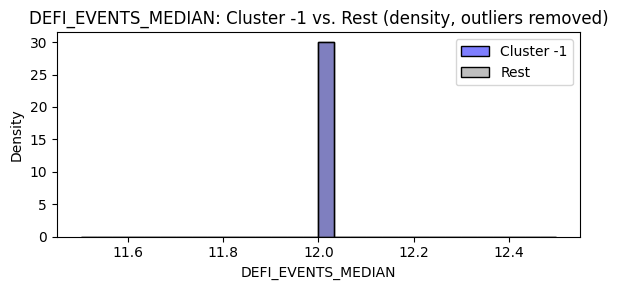

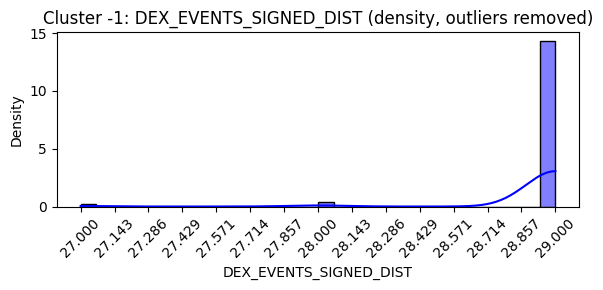

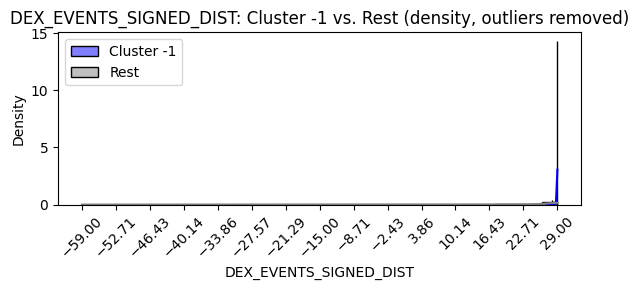

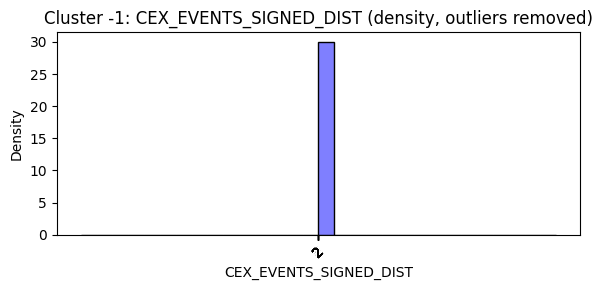

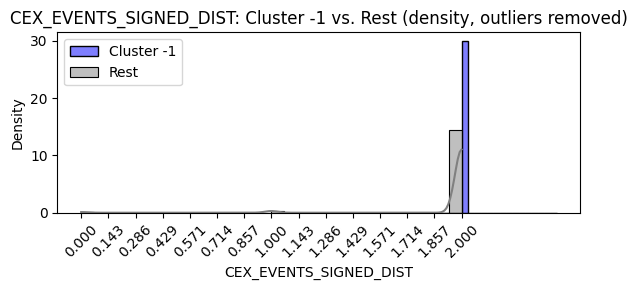

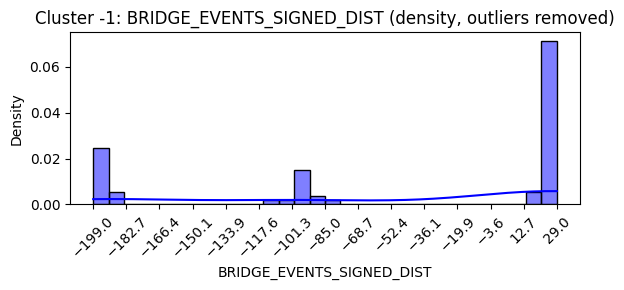

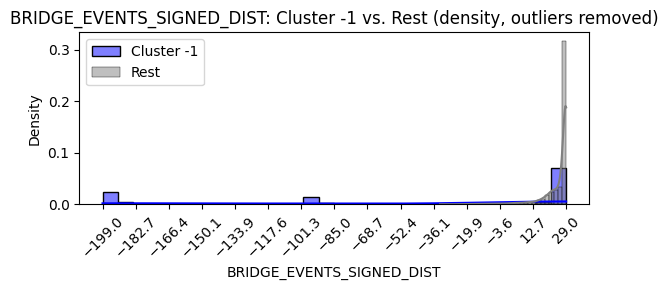

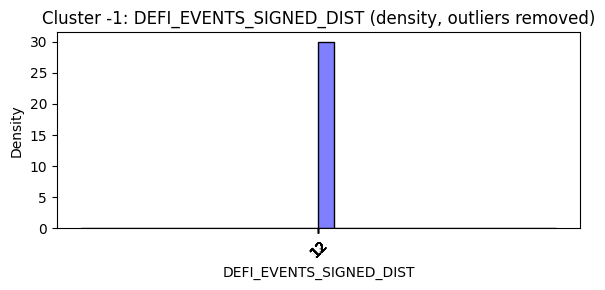

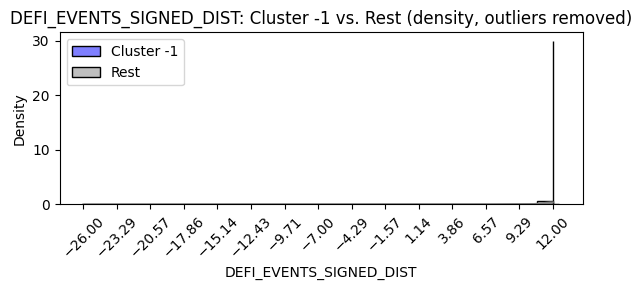

In [59]:
# Cluster-Specific Analytic Score Visualisations (with improved x-axis for *_SIGNED_DIST columns)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cluster_score_distributions(df, cluster_col, score_cols, bottom_percentile=2.5, top_percentile=97.5):
    """
    For each cluster, plot:
      1. Distribution of each analytic score for that cluster only.
      2. Overlayed density plot: cluster vs. all other wallets.
      For *_SIGNED_DIST columns, increase x-tick frequency for readability.
    """
    signed_dist_cols = [c for c in score_cols if c.endswith('_SIGNED_DIST')]
    clusters = df[cluster_col].unique()
    for cluster in clusters:
        cluster_df = df[df[cluster_col] == cluster]
        rest_df = df[df[cluster_col] != cluster]
        print(f'\n--- Cluster {cluster} ({len(cluster_df)} wallets) ---')
        for col in score_cols:
            # Trim percentiles for both cluster and rest
            c_low, c_high = np.percentile(cluster_df[col], bottom_percentile), np.percentile(cluster_df[col], top_percentile)
            r_low, r_high = np.percentile(rest_df[col], bottom_percentile), np.percentile(rest_df[col], top_percentile)
            cluster_trimmed = cluster_df[(cluster_df[col] >= c_low) & (cluster_df[col] <= c_high)][col]
            rest_trimmed = rest_df[(rest_df[col] >= r_low) & (rest_df[col] <= r_high)][col]

            # 1. Distribution for cluster only
            plt.figure(figsize=(6,3))
            sns.histplot(cluster_trimmed, kde=True, bins=30, stat='density', color='blue')
            plt.title(f'Cluster {cluster}: {col} (density, outliers removed)')
            plt.xlabel(col)
            plt.ylabel('Density')
            if col in signed_dist_cols:
                # Set more frequent x-ticks for readability
                ticks = np.linspace(cluster_trimmed.min(), cluster_trimmed.max(), 15)
                plt.xticks(ticks, rotation=45)
            plt.tight_layout()
            plt.show()

            # 2. Overlay: cluster vs. rest
            plt.figure(figsize=(6,3))
            sns.histplot(cluster_trimmed, kde=True, bins=30, stat='density', color='blue', label=f'Cluster {cluster}')
            sns.histplot(rest_trimmed, kde=True, bins=30, stat='density', color='grey', label='Rest', alpha=0.5)
            plt.title(f'{col}: Cluster {cluster} vs. Rest (density, outliers removed)')
            plt.xlabel(col)
            plt.ylabel('Density')
            if col in signed_dist_cols:
                ticks = np.linspace(min(cluster_trimmed.min(), rest_trimmed.min()), max(cluster_trimmed.max(), rest_trimmed.max()), 15)
                plt.xticks(ticks, rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

# Example usage:
cluster_col = 'activity_cluster_label'
# Use same score_cols as in previous cell (after 'activity_cluster_label')
start_col = df.columns.get_loc(cluster_col) + 1
score_cols = df.columns[start_col:]
plot_cluster_score_distributions(df, cluster_col, score_cols)

BELOW IS LOOKING AT THE POSSIBLE "STABLE HIGH-VALUE TRADER" POTENTIAL BEHAVIOURAL ARCHETYPE

Stable high-value traders: 1034 wallets (5.1% of total)


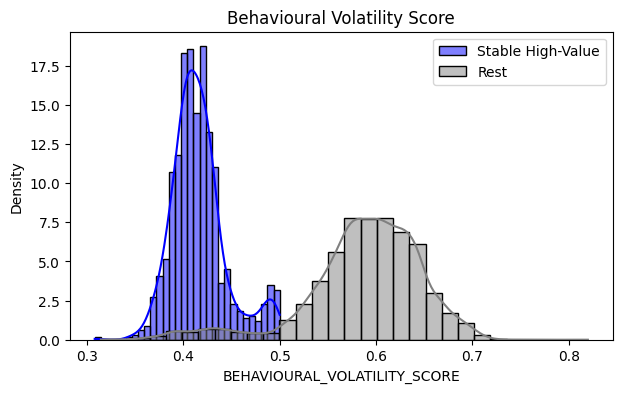

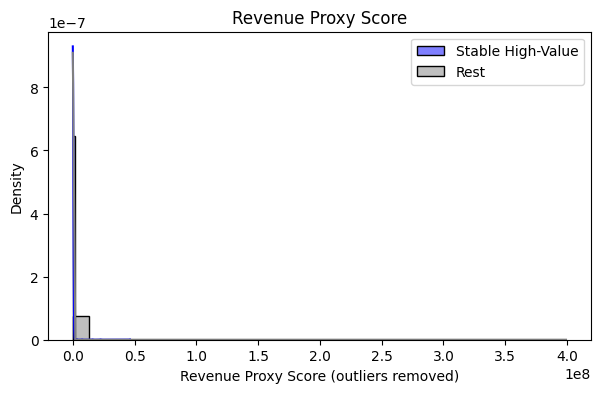

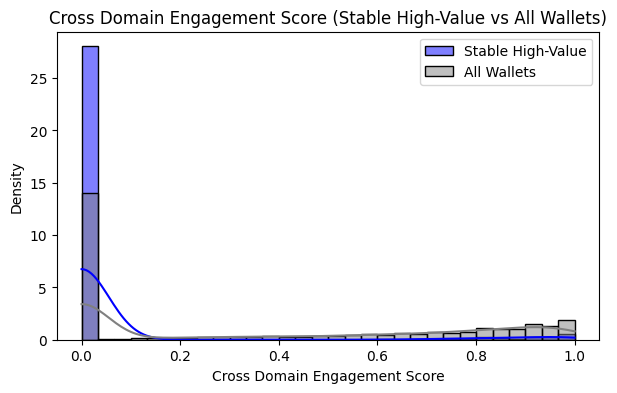

In [60]:
# Identify 'stable high-value traders' and compare to rest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_group_comparison(data1, data2, col, label1, label2, title, xlabel=None, bottom_percentile=0, top_percentile=100, stat='density'):
    """
    Plots two distributions for a given column, with optional exclusion of bottom/top percentiles.
    """
    d1 = data1[col]
    d2 = data2[col]
    if bottom_percentile > 0 or top_percentile < 100:
        low1 = np.percentile(d1, bottom_percentile)
        high1 = np.percentile(d1, top_percentile)
        d1 = d1[(d1 >= low1) & (d1 <= high1)]
        low2 = np.percentile(d2, bottom_percentile)
        high2 = np.percentile(d2, top_percentile)
        d2 = d2[(d2 >= low2) & (d2 <= high2)]
    plt.figure(figsize=(7,4))
    sns.histplot(d1, color='blue', kde=True, bins=30, label=label1, stat=stat)
    sns.histplot(d2, color='grey', kde=True, bins=30, label=label2, stat=stat, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel if xlabel else col)
    plt.ylabel('Count' if stat=='count' else 'Density')
    plt.legend()
    plt.show()

# Define score columns
vol_col = 'BEHAVIOURAL_VOLATILITY_SCORE'
rev_col = 'REVENUE_SCORE_PROXY'
cross_col = 'CROSS_DOMAIN_ENGAGEMENT_SCORE'
im_dist_cols = [col for col in df.columns if col.endswith('_NORM_DIST')]


#**MAYBE ISSUE WITH REVENUE IS THE DIMENSIONS OF THE Y AND X AXIS?? - EXPLORE THIS**

# Calculate thresholds
vol_thresh = 0.5  # Set volatility threshold to 0.5
rev_thresh = np.percentile(df[rev_col], 75)  # Set revenue threshold to 90th percentile

# Select group: volatility < 0.5, high revenue
stable_high_value = df[(df[vol_col] < vol_thresh) & (df[rev_col] >= rev_thresh)]
rest = df[~((df[vol_col] < vol_thresh) & (df[rev_col] >= rev_thresh))]

print(f"Stable high-value traders: {len(stable_high_value)} wallets ({len(stable_high_value)/len(df)*100:.1f}% of total)")

# Example: Remove top and bottom 1% outliers for all plots
bottom_percentile = 0
top_percentile = 100

# 1. Distribution of volatility (comparison)
plot_group_comparison(stable_high_value, rest, vol_col, 'Stable High-Value', 'Rest', 'Behavioural Volatility Score', bottom_percentile=bottom_percentile, top_percentile=top_percentile)

# 2. Distribution of revenue (comparison) - use density on y-axis
plot_group_comparison(stable_high_value, rest, rev_col, 'Stable High-Value', 'Rest', 'Revenue Proxy Score', xlabel='Revenue Proxy Score (outliers removed)', bottom_percentile=bottom_percentile, top_percentile=top_percentile, stat='density')

# 3. Cross Domain Engagement Score: compare group to whole dataset
plot_group_comparison(stable_high_value, df, cross_col, 'Stable High-Value', 'All Wallets', 'Cross Domain Engagement Score (Stable High-Value vs All Wallets)', xlabel='Cross Domain Engagement Score', bottom_percentile=bottom_percentile, top_percentile=top_percentile)

# 4. Interaction Mode Distance Scores: compare group vs rest
for col in im_dist_cols:
    plot_group_comparison(stable_high_value, rest, col, 'Stable High-Value', 'Rest', f'{col} (Stable High-Value vs Rest)', bottom_percentile=bottom_percentile, top_percentile=top_percentile)

THE BELOW IS LOOKING AT THE POTENTIAL "ERRATIC SPECULATOR" BEHAVIOURAL ARCHETYPE

Wallets with BEHAVIOURAL_VOLATILITY_SCORE > 0.6 and CROSS_DOMAIN_ENGAGEMENT_SCORE < 0.25: 6079 (30.13% of total)


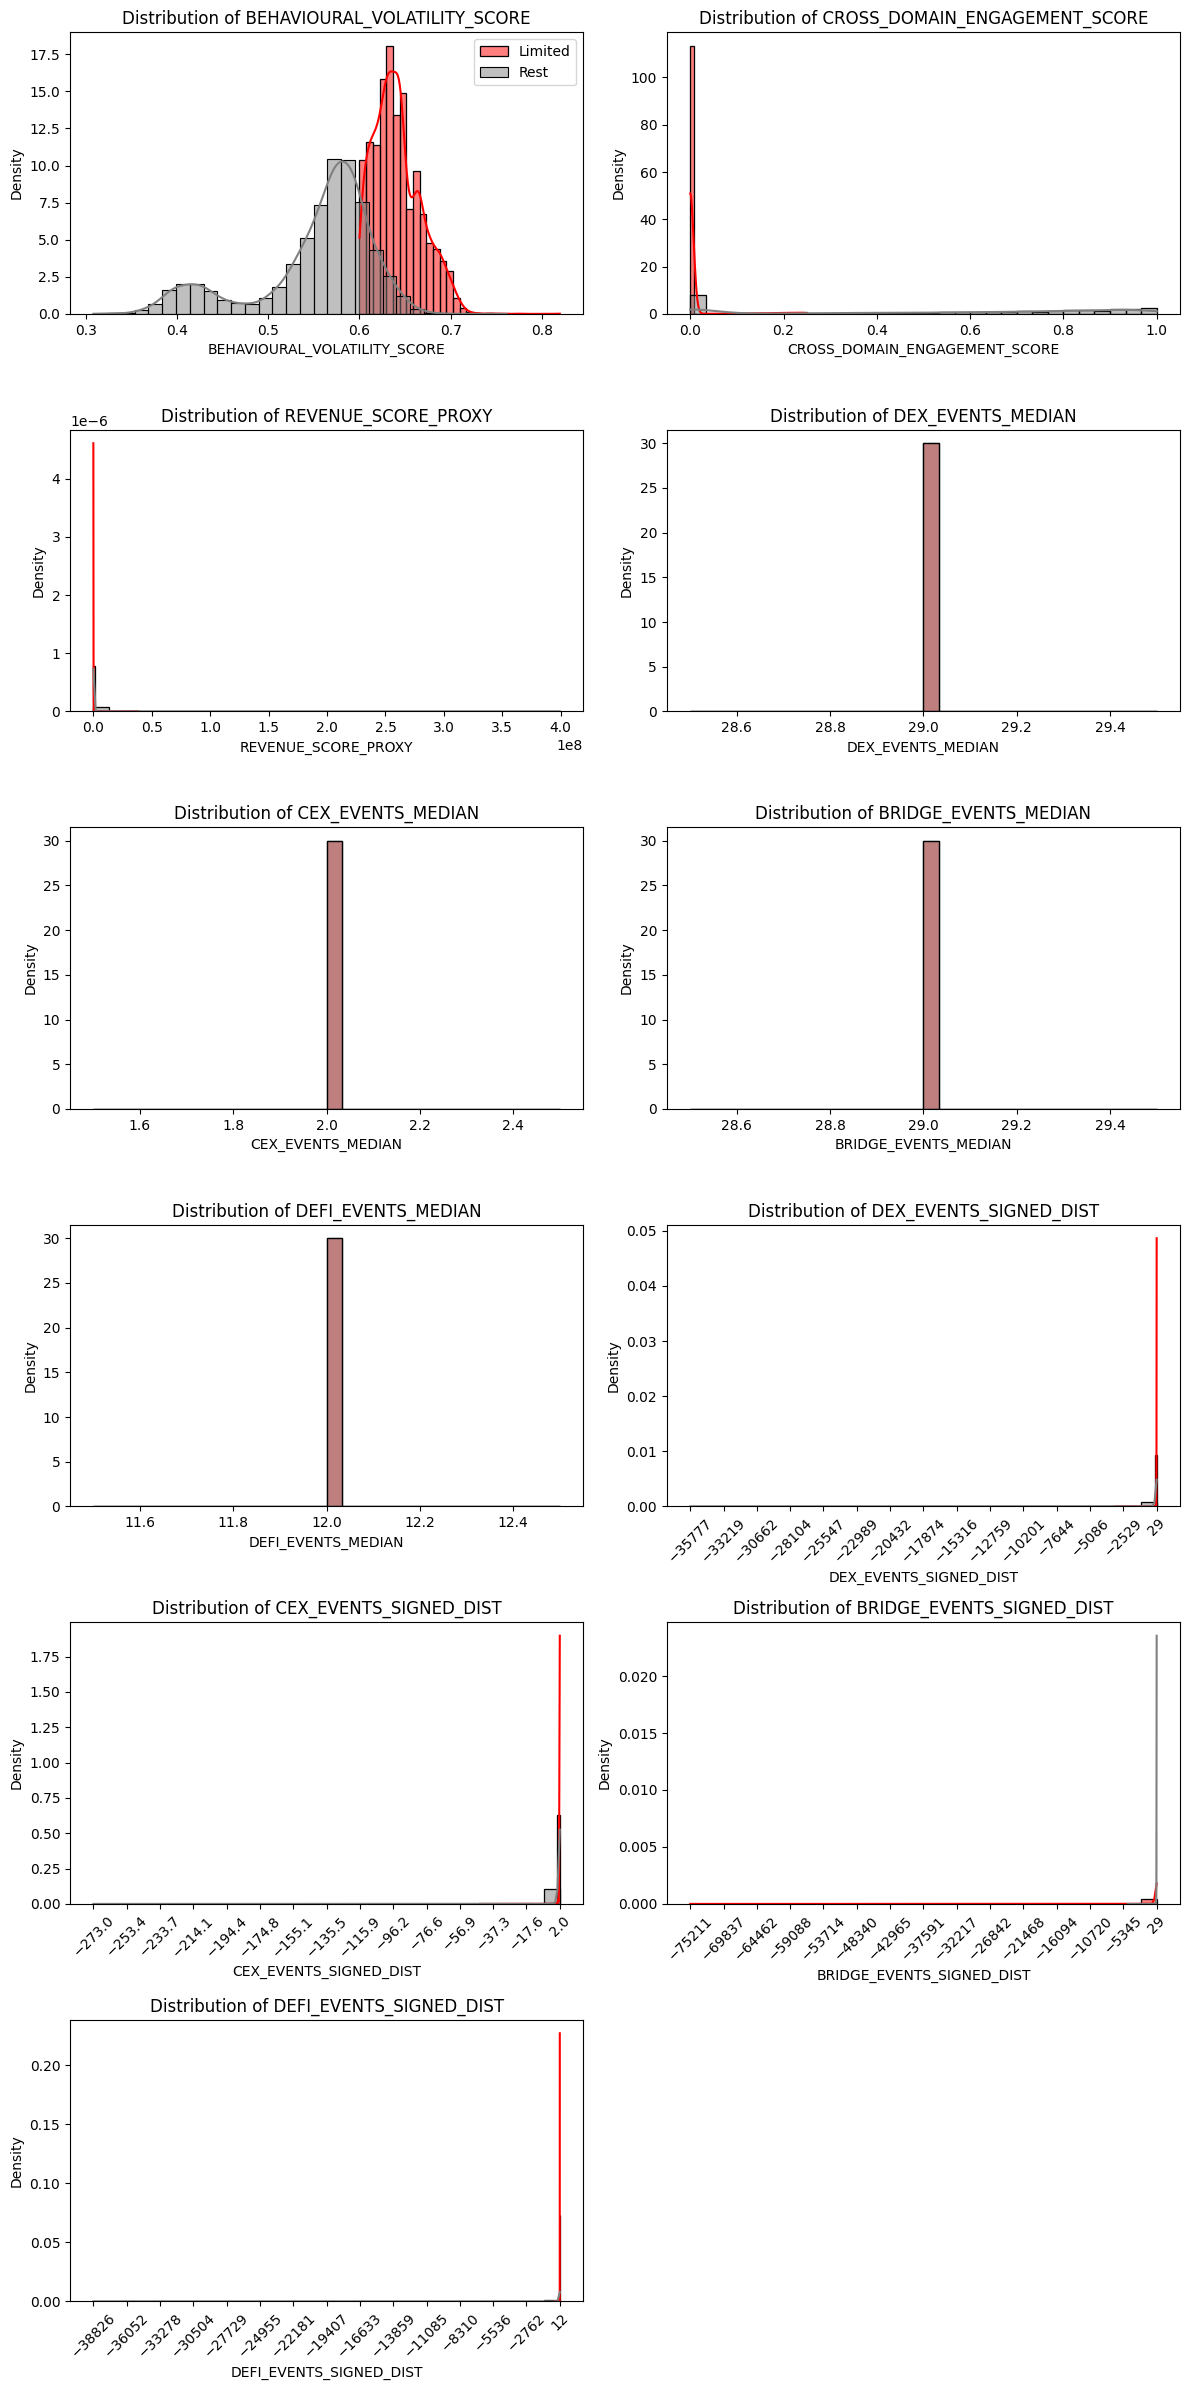

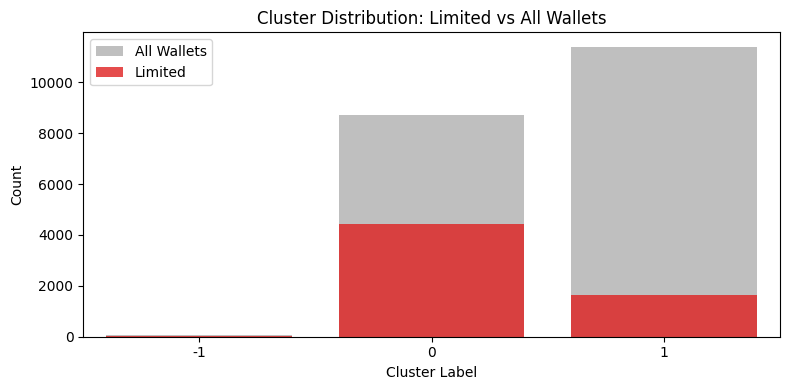

In [61]:
# Compare wallets with high volatility (>0.6) and low cross-domain engagement (<0.25) to the rest, and visualise their cluster distribution and all other analytic scores
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define analytic score columns (update if your column names differ)
vol_col = 'BEHAVIOURAL_VOLATILITY_SCORE'
cross_col = 'CROSS_DOMAIN_ENGAGEMENT_SCORE'
cluster_col = 'activity_cluster_label'
# Use score_cols from previous cells if available, else define manually if needed
# score_cols = [vol_col, cross_col, ...]
# If not defined, get all columns after 'activity_cluster_label'
if 'score_cols' not in locals():
    start_col = df.columns.get_loc(cluster_col) + 1
    score_cols = df.columns[start_col:]

# Select wallets with the specified limitations
limited = df[(df[vol_col] > 0.6) & (df[cross_col] < 0.25)]
rest = df[~((df[vol_col] > 0.6) & (df[cross_col] < 0.25))]

print(f"Wallets with {vol_col} > 0.6 and {cross_col} < 0.25: {len(limited)} ({len(limited)/len(df)*100:.2f}% of total)")

# 1. Visualise the distribution of all analytic scores for both groups
num_cols = len(score_cols)
fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(12, 4 * ((num_cols + 1) // 2)))
axes = axes.flatten()
for i, col in enumerate(score_cols):
    sns.histplot(limited[col], color='red', label='Limited', kde=True, stat='density', bins=30, ax=axes[i])
    sns.histplot(rest[col], color='grey', label='Rest', kde=True, stat='density', bins=30, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    if i == 0:
        axes[i].legend()
    # Improve x-tick frequency for *_SIGNED_DIST columns
    if col.endswith('_SIGNED_DIST'):
        ticks = np.linspace(min(limited[col].min(), rest[col].min()), max(limited[col].max(), rest[col].max()), 15)
        axes[i].set_xticks(ticks)
        for label in axes[i].get_xticklabels():
            label.set_rotation(45)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

# 2. Visualise which clusters the limited wallets are in, compared to the rest
plt.figure(figsize=(8,4))
sns.countplot(x=cluster_col, data=df, order=sorted(df[cluster_col].unique()), color='grey', label='All Wallets', alpha=0.5)
sns.countplot(x=cluster_col, data=limited, order=sorted(df[cluster_col].unique()), color='red', label='Limited', alpha=0.8)
plt.title('Cluster Distribution: Limited vs All Wallets')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

Wallets with DEFI_EVENTS_SIGNED_DIST < 28: 20174 (100.00% of total)


IndexError: index -1 is out of bounds for axis 0 with size 0

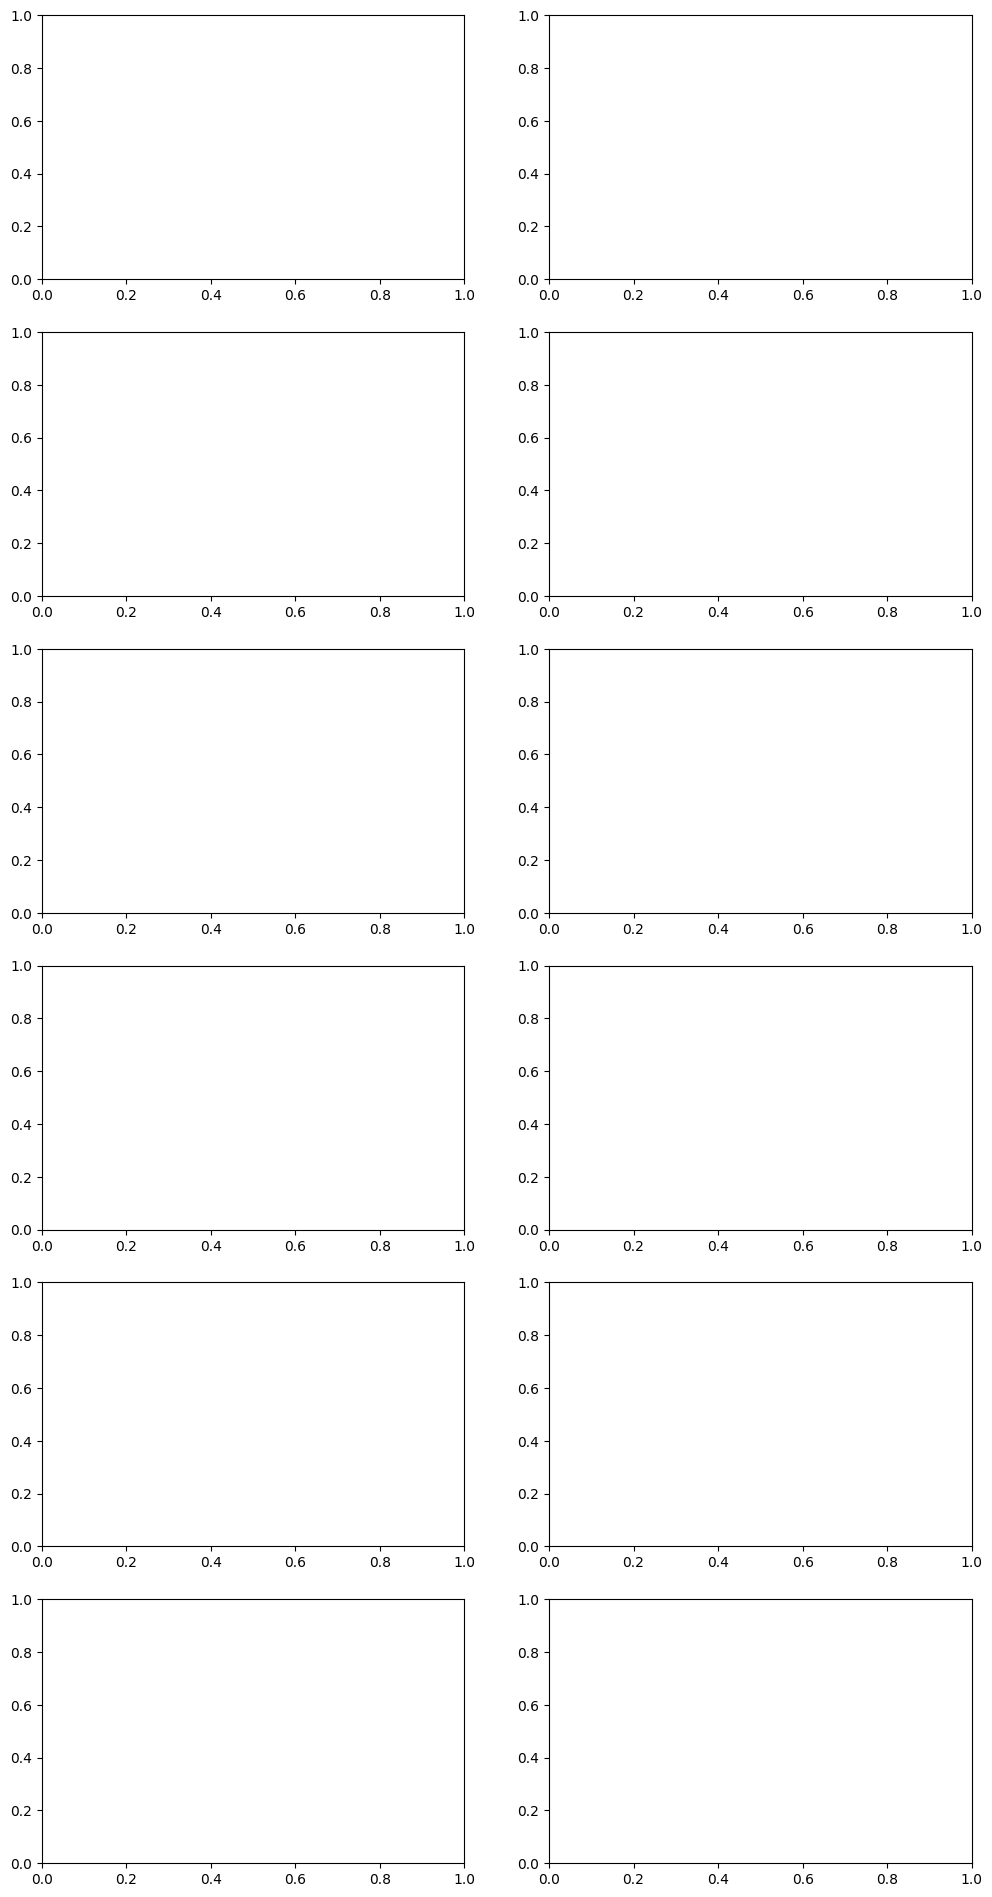

In [66]:
# Compare wallets with DEFI_EVENTS_SIGNED_DIST < 28 to the rest, and visualise all analytic scores and cluster distribution, with optional outlier removal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the relevant column
defi_dist_col = 'DEFI_EVENTS_SIGNED_DIST'
cluster_col = 'activity_cluster_label'
# Use score_cols from previous cells if available, else define manually if needed
if 'score_cols' not in locals():
    start_col = df.columns.get_loc(cluster_col) + 1
    score_cols = df.columns[start_col:]

# Set percentiles for outlier removal (set to 0 and 100 for no trimming)
bottom_percentile = 10
top_percentile = 100

# Select wallets with the specified limitation
limited = df[df[defi_dist_col] < 28]
rest = df[~(df[defi_dist_col] < 28)]

print(f"Wallets with {defi_dist_col} < 28: {len(limited)} ({len(limited)/len(df)*100:.2f}% of total)")

# 1. Visualise the distribution of all analytic scores for both groups, with optional outlier removal
num_cols = len(score_cols)
fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(12, 4 * ((num_cols + 1) // 2)))
axes = axes.flatten()
for i, col in enumerate(score_cols):
    # Remove outliers using percentiles if specified
    lim_low, lim_high = np.percentile(limited[col], bottom_percentile), np.percentile(limited[col], top_percentile)
    rest_low, rest_high = np.percentile(rest[col], bottom_percentile), np.percentile(rest[col], top_percentile)
    limited_trimmed = limited[(limited[col] >= lim_low) & (limited[col] <= lim_high)][col]
    rest_trimmed = rest[(rest[col] >= rest_low) & (rest[col] <= rest_high)][col]
    sns.histplot(limited_trimmed, color='red', label='Limited', kde=True, stat='density', bins=30, ax=axes[i])
    sns.histplot(rest_trimmed, color='grey', label='Rest', kde=True, stat='density', bins=30, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    if i == 0:
        axes[i].legend()
    # Improve x-tick frequency for *_SIGNED_DIST columns
    if col.endswith('_SIGNED_DIST'):
        ticks = np.linspace(min(limited_trimmed.min(), rest_trimmed.min()), max(limited_trimmed.max(), rest_trimmed.max()), 15)
        axes[i].set_xticks(ticks)
        for label in axes[i].get_xticklabels():
            label.set_rotation(45)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

# 2. Visualise which clusters the limited wallets are in, compared to the rest
plt.figure(figsize=(8,4))
sns.countplot(x=cluster_col, data=df, order=sorted(df[cluster_col].unique()), color='grey', label='All Wallets', alpha=0.5)
sns.countplot(x=cluster_col, data=limited, order=sorted(df[cluster_col].unique()), color='red', label='Limited', alpha=0.8)
plt.title('Cluster Distribution: Limited vs All Wallets')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()